In [23]:
import psycopg2 as pg
import pandas.io.sql as psql
from datetime import datetime
import json

conn_str = "host={0} port={1} dbname={2} user={3} password={4}" \
.format("localhost", 5432, "kanjidb", "postgres", "w0lfpack")

try:
    conn = pg.connect(conn_str)
    print("Welcome to Jupyter Notebook.  You are connected to the Kanji database!")
except pg.OperationalError:
    print("You are not connected to the database.")

Welcome to Jupyter Notebook.  You are connected to the Kanji database!


In [24]:
#_CONTROLLER_DEVICE_ID = sys.argv[1]
_CONTROLLER_DEVICE_ID = 10020

In [25]:
_STATUS_ONLINE = 10001
_DEPLOY_STATE_MAINTENANCE = 10002
_REPORT_INTERVAL_MINS = 720

_DIAGNOSTIC_MESSAGE = 99
_HAPPYZONE_SET = 31
_TEMPF_AVERAGE = 34

_COOLING = 32
_HEATING = 33

_STATIC_IMAGE_PATH = '/home/sensei/senseiweb/kanji-static/images'
_SERVER_IP = '65.188.101.48'

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']


In [26]:
import time
import operator

now = datetime.now()

#timestart = now - datetime.timedelta(hours=1, minutes=15)
#querytime = timestart.strftime("%Y/%m/%d %H:%M:%S")
#print("report period {0} - {1}".format(timestart, now))

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def isint(value):
  try:
    int(value)
    return True
  except ValueError:
    return False

def printlines(lines):
    for i in range(len(lines)):
       print("{0}. {1}/{2}".format(i,lines[i]['type'],lines[i]['label']))
       for j in range(len(lines[i]['values'])):
          print("{0} {1}".format(lines[i]['values'][j][0], lines[i]['values'][j][1]))

def lineindex(lines, pintype):
    for i in range(len(lines)):
        if lines[i]['type']==pintype:
            return i
    #create a new line for this pintype
    qlabel = 'SELECT description FROM kanji_sensortype WHERE idsensortype={0}'.format(pintype)
    #print(qlabel)
    cur = conn.cursor()
    cur.execute(qlabel)
    label = cur.fetchone()[0]
    line = {}
    values = []
    line['type'] = pintype
    line['label']  = label
    line['color']  = colors[len(lines)]
    line['values'] = values
    lines.append(line)
    return(len(lines)-1)

query = "SELECT timestamp, eventdata FROM kanji_eventlog eventlog WHERE eventlog.timestamp>= NOW() - INTERVAL '{0} minutes' \
AND (eventlog.node_id={1})".format(_REPORT_INTERVAL_MINS, _CONTROLLER_DEVICE_ID) 

print(query)

print("Today is {0}".format(now))
cur = conn.cursor()
cur.execute(query)
rows = cur.fetchall()
if len(rows) > 0:
    print("The query returned {0} rows.".format(len(rows)))
    lines = []
    for row in rows:        
        timestamp = row[0].strftime("%Y-%m-%d %H:%M")
        #timestamp = row[0].strftime("%m-%d %I:%M%p")
        pins = json.loads(row[1])
        for pin in pins:            
            pintype  = pin['t']
            pinvalue = pin['v']
            pidx = lineindex(lines,pintype)
            value = {}
            if isfloat(pinvalue):
                value = (timestamp, float(pinvalue))
            elif isint(pinvalue):
                value = (timestamp, int(pinvalue))
            else:
                value = (timestamp, pinvalue)
            lines[pidx]['values'].append(value)       
    print("There are {0} lines for this query.".format(len(lines)))
    #printlines(lines)
else:
    print("The query returned empty.")
    

SELECT timestamp, eventdata FROM kanji_eventlog eventlog WHERE eventlog.timestamp>= NOW() - INTERVAL '720 minutes' AND (eventlog.node_id=10020)
Today is 2019-03-27 13:25:41.433959
The query returned 2074 rows.
There are 5 lines for this query.


#Line Chart

rendering the HAPPY_ZONE triggers
label=CURRENT TEMP F min=62.4 max=72.7
  first axis set
label=AVG TEMP F min=65.0 max=70.9
70.9<72.7 and 65.0>62.4 and (70.9-65.0)/(72.7-62.4>0.5
  using axis (<matplotlib.axes._subplots.AxesSubplot object at 0x7f9453ece9b0>, 72.7, 62.4)
label=COOLING min=0.0 max=0.0
0.0<72.7 and 0.0>62.4 and (0.0-0.0)/(72.7-62.4>0.5
  creating new axis
label=HEATING min=0.0 max=0.0
0.0<72.7 and 0.0>62.4 and (0.0-0.0)/(72.7-62.4>0.5
0.0<0.0 and 0.0>0.0 and (0.0-0.0)/(0.0-0.0>0.5
  creating new axis
laying in the HappyZones max=95.0 min=45.0
Saving chart to channel_03_27_2019_132541.png


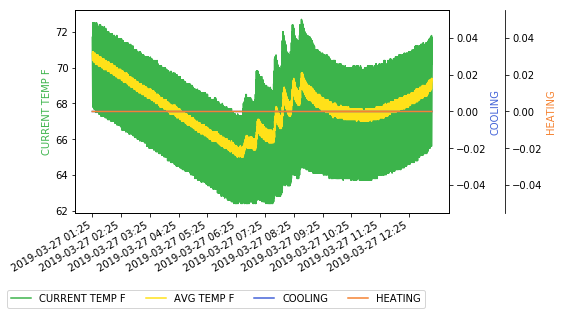

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import numpy as np

primaryset = False
postplot = False
axes = []
linenum = 0
for line in lines:
    if line['type']!=_HAPPYZONE_SET and line['type']!=_DIAGNOSTIC_MESSAGE :
      dtime = []
      values = [] 
      line['values'].sort(key = operator.itemgetter(0))  
      for i in range(len(line['values'])):
        linedata = line['values'][i]
        dtime.append(linedata[0])
        values.append(linedata[1])
      maxval = max(values)
      minval = min(values)
      print("label={0} min={1} max={2}".format(line['label'], minval, maxval))
      if primaryset == True:
        axisfit = False
        for axis in axes:
          #looking for an existing axes that we can fit nicely into
          #print(axis)
          print("{0}<{1} and {2}>{3} and ({4}-{5})/({6}-{7}>0.5".format(maxval,axis[1],minval,axis[2],maxval,minval,axis[1],axis[2]))
          if (maxval<axis[1]) and (minval>axis[2]) and (((maxval - minval)/(axis[1]-axis[2]))>0.5):
            ax = axis[0]
            print("  using axis {0}".format(axis))
            plt.plot(dtime, values, line['color'], label=line['label'])
            axisfit = True
            break
        if axisfit==False:
          #create new axes
          print("  creating new axis")
          ax = axes[0][0].twinx()
          ax.spines["right"].set_position(("axes", ((len(axes)+1)*.15) + .70 ))  
          plt.plot(dtime, values, line['color'], label=line['label'])
          ax.set_ylabel(line['label'], color=line['color'])
          ax.fmt_xdata = mdates.DateFormatter('%H-%M')
          axes.append((ax, maxval, minval))
      else:
        #this is the first plot
        fig, ax = plt.subplots(figsize=(8,4))
        print("  first axis set")
        plt.plot(dtime, values, line['color'], label=line['label'])
        ax.set_ylabel(line['label'], color=line['color'])
        primaryset = True
        axes.append((ax, maxval, minval))
      if line['type']==_HEATING:
        ax.fill_between(dtime, 0, values, facecolor=line['color'], alpha=0.1)
      if line['type']==_COOLING:
        ax.fill_between(dtime, 0, values, facecolor=line['color'], alpha=0.1)
      ax.set_xticks(ax.get_xticks()[::60])
    elif line['type']==_HAPPYZONE_SET:
      print("rendering the HAPPY_ZONE triggers")
      postplot = True
      #everything we need to plot the trigger lines is in the first record      
      triggerpoints = line['values'][0][1].replace('[','').replace(']','').split(',')
      tp1 = int(triggerpoints[0]) + int(triggerpoints[1])/2
      hzminval = int(triggerpoints[0]) - int(triggerpoints[1])/2
      hzmaxval = int(triggerpoints[2]) + int(triggerpoints[3])/2
      tp4 = int(triggerpoints[2]) - int(triggerpoints[3])/2
    linenum += 1
if postplot==True:
  print("laying in the HappyZones max={0} min={1}".format(hzmaxval,hzminval))
  try:
    dtime
    for axis in axes:
       #print(axis)
       #looking for an existing axes that we can sort of fit into
       if (0.8*hzmaxval<axis[1]) and (1.2*hzminval>axis[2]) and (((hzmaxval-hzminval)/(axis[1]-axis[2]))>0.5):
         print("  using {0}".format(axis))
         ax = axis[0]
         tp1arr = [ tp1 for i in range(len(dtime)) ]
         tp2arr = [ hzminval for i in range(len(dtime)) ]
         ax.fill_between(dtime, tp2arr, tp1arr, facecolor='red', alpha=0.15)
         tp3arr = [ hzmaxval for i in range(len(dtime)) ]
         tp4arr = [ tp4 for i in range(len(dtime)) ]
         ax.fill_between(dtime, tp4arr, tp3arr, facecolor='blue', alpha=0.15)
         break
  except NameError:
    print("dtime is not defined")

 
fig.legend(bbox_to_anchor=(0,-.1), loc="lower left", bbox_transform=fig.transFigure, ncol=6)
fig.autofmt_xdate()
fig.tight_layout()

_IMAGE_NAME = "channel_{0}.png".format(now.strftime("%m_%d_%Y_%H%M%S"))
print("Saving chart to {0}".format(_IMAGE_NAME))
#plt.show()
fig.savefig('{0}/{1}'.format(_STATIC_IMAGE_PATH,_IMAGE_NAME), bbox_inches="tight")


In [28]:
headsection    = {"type": "section","text": {"type": "plain_text","text": "*PorterFarms - MeshIO Sensor Status*"}}
closesection   = {"type": "context","elements": [{"type": "plain_text","text": "For more info, contact support@porterfarms.inc"}]} 
dividersection = {"type": "divider"}

import requests
import json

apixutoken = "9a6a932b75264cc9b9b233936191603"
apixuforecasturl = "https://api.apixu.com/v1/forecast.json?key=156546499eb44cb9b65234101191703&q="
print(apixuforecasturl)

https://api.apixu.com/v1/forecast.json?key=156546499eb44cb9b65234101191703&q=


In [30]:
from slackclient import SlackClient
import io

#print(now.strftime("%I:%M %p %A, %B %e, %Y"))

#get the latest average temperature, get the last 5minutes in descending timestamp order
query = "SELECT timestamp, eventdata FROM kanji_eventlog eventlog WHERE  \
(eventlog.node_id={0}) ORDER BY timestamp desc LIMIT 10".format(_CONTROLLER_DEVICE_ID)

print(query)

cur = conn.cursor()
cur.execute(query)
latestevent = cur.fetchall()[0]
timestamp = latestevent[0]
print("Latest data is from {0}".format(print(timestamp.strftime("%I:%M %p %A, %B %e, %Y"))))
#print(latestevent[1])
eventpins = json.loads(latestevent[1])
for eventpin in eventpins:
    if eventpin['t'] == _TEMPF_AVERAGE:
      latestaveragetemp = float(eventpin['v'])
    elif eventpin['t'] == _HEATING:
      if int(eventpin['v'])==1:
        heatstatus = "ACTIVE"
      else:
        heatstatus = "IDLE"
    elif eventpin['t'] == _COOLING:
      if int(eventpin['v'])==1:
        coolstatus = "ACTIVE"
      else:
        coolstatus = "IDLE" 
        
#get temperature yesterday at this time
query = "SELECT timestamp, eventdata FROM kanji_eventlog eventlog WHERE eventlog.timestamp>= NOW() - INTERVAL '{0} hours' \
AND (eventlog.node_id={1}) ORDER BY timestamp asc".format(24, _CONTROLLER_DEVICE_ID)

cur = conn.cursor()
cur.execute(query)
yesterdayevent = cur.fetchall()
eventpins = json.loads(yesterdayevent[0][1])
yesterdayaveragetempdiff  = 0.0
for eventpin in eventpins:
    if eventpin['t'] == _TEMPF_AVERAGE:
      yesterdayaveragetempdiff = latestaveragetemp - float(eventpin['v'])
#end get temperature yesterday at this time

#get temperature three hours ago
query = "SELECT timestamp, eventdata FROM kanji_eventlog eventlog WHERE eventlog.timestamp>= NOW() - INTERVAL '{0} hours' \
AND (eventlog.node_id={1}) ORDER BY timestamp asc".format(3, _CONTROLLER_DEVICE_ID)

cur = conn.cursor()
cur.execute(query)
yesterdayevent = cur.fetchall()
eventpins = json.loads(yesterdayevent[0][1])
threehouragoaveragetempdiff = 0.0
for eventpin in eventpins:
    if eventpin['t'] == _TEMPF_AVERAGE:
      threehouragoaveragetempdiff = latestaveragetemp - float(eventpin['v'])    
#end get temperature three hours ago

#get temperature one hour ago
query = "SELECT timestamp, eventdata FROM kanji_eventlog eventlog WHERE eventlog.timestamp>= NOW() - INTERVAL '{0} hours' \
AND (eventlog.node_id={1}) ORDER BY timestamp asc".format(1, _CONTROLLER_DEVICE_ID)

cur = conn.cursor()
cur.execute(query)
yesterdayevent = cur.fetchall()
eventpins = json.loads(yesterdayevent[0][1])
houragoaveragetempdiff = 0.0
for eventpin in eventpins:
    if eventpin['t'] == _TEMPF_AVERAGE:
      houragoaveragetempdiff = latestaveragetemp - float(eventpin['v'])
#end get temperature one hour ago

#get controller location
query = "SELECT node.name, node.setupstring, location.description, location.zipcode, location.imageurl, location.slackchannel, customer.slacktoken FROM kanji_node node \
JOIN kanji_location location on node.location_id=location.idlocation \
JOIN kanji_customer customer on location.customer_id=customer.idcustomer \
WHERE node.idnode={0}".format(_CONTROLLER_DEVICE_ID)


#print(query)
cur = conn.cursor()
cur.execute(query)
controllerlocation = cur.fetchone()

nodesetup = json.loads(controllerlocation[1])
location = controllerlocation[2]
zipcode  = controllerlocation[3]
locationimageurl  = controllerlocation[4]
_CHANNEL_NAME = controllerlocation[5]
_SLACK_TOKEN = controllerlocation[6]

historyurl = "https://{0}/kanji/{1}".format(_SERVER_IP,_IMAGE_NAME)

if locationimageurl is None:
  locationimageurl = 'https://www.dropbox.com/s/k8td4cmja7vs30r/building.jpg?raw=1' 

print("Using location image at {0}".format(locationimageurl))

# Get Weather Info
weatherurl = "{0}{1}".format(apixuforecasturl,zipcode)
#print(weatherurl)
resp = requests.get(weatherurl, timeout=(15, 30))
weather = resp.json()
todayscurrent = weather["current"]
#print(todayscurrent)
temp_f = todayscurrent["temp_f"]
humidity = todayscurrent["humidity"]
#wind_mph
#wind_dir
feelslike_f = todayscurrent["feelslike_f"]
#print(temp_f)
todaysforecast = weather["forecast"]["forecastday"][0]["day"]
#print(todaysforecast)
maxtemp_f = todaysforecast["maxtemp_f"]
mintemp_f = todaysforecast["mintemp_f"]
maxwind_mph = todaysforecast["maxwind_mph"]
totalprecip_in = todaysforecast["totalprecip_in"]
avghumidity = todaysforecast["avghumidity"]
conditions = todaysforecast["condition"]["text"]
uv = todaysforecast["uv"]
#print("{0} \n {1} \n {2} \n {3} \n {4} \n {5} \n {6}".format(maxtemp_f,mintemp_f,maxwind_mph,totalprecip_in,avghumidity,conditions,uv))
# End Get Weather Info

#the block is constructed here from the Slack template, we replace keys as needed later
messagestring = "[\
   {\"type\": \"section\", \
		\"text\": { \
			\"type\": \"mrkdwn\", \
			\"text\": \"*<fakeLink.toUserProfiles.com|Iris / Zelda 1-1>*\\nTuesday, January 21 4:00-4:30pm\\nBuilding 2 - Havarti Cheese (3)\\n2 guests\" \
		}, \
		\"accessory\": { \
			\"type\": \"image\", \
			\"image_url\": \"https://api.slack.com/img/blocks/bkb_template_images/notifications.png\", \
			\"alt_text\": \"calendar thumbnail\" \
		} \
	}, \
	{\"type\": \"context\", \
		\"elements\": [ \
			{ \
				\"type\": \"image\", \
				\"image_url\": \"https://www.dropbox.com/s/o2gjgfsph2cxgds/thermometer.jpg?raw=1\", \
				\"alt_text\": \"notifications warning icon\" \
			}, \
			{ \
				\"type\": \"mrkdwn\", \
				\"text\": \"*Conflicts with Team Huddle: 4:15-4:30pm*\" \
			} \
		] \
	}, \
    {\"type\": \"context\", \
		\"elements\": [ \
			{ \
				\"type\": \"image\", \
				\"image_url\": \"https://www.dropbox.com/s/pw6329yc2ge05cr/gear.png?raw=1\", \
				\"alt_text\": \"notifications warning icon\" \
			}, \
			{ \
				\"type\": \"mrkdwn\", \
				\"text\": \"*Conflicts with Team Huddle: 4:15-4:30pm*\" \
			} \
		] \
	}, \
    {\"type\": \"context\", \
		\"elements\": [ \
			{ \
				\"type\": \"image\", \
				\"image_url\": \"https://api.slack.com/img/blocks/bkb_template_images/notificationsWarningIcon.png\", \
				\"alt_text\": \"notifications warning icon\" \
			}, \
			{ \
				\"type\": \"mrkdwn\", \
				\"text\": \"*Controller is in SUPERVISORY MODE*\" \
			} \
		] \
	}, \
   	{ \
		\"type\": \"divider\" \
	}, \
    { \
		\"type\": \"section\", \
		\"text\": { \
			\"type\": \"mrkdwn\", \
			\"text\": \"*Accessory text.*\" \
		}, \
		\"accessory\": { \
			\"type\": \"button\", \
			\"text\": { \
				\"type\": \"plain_text\", \
				\"text\": \"BUTTON_TEXT\" \
			}, \
			\"value\": \"BUTTON_VALUE\", \
			\"action_id\": \"button\" \
		} \
	} \
]"

blockmessage = json.loads(messagestring)

# start key replacement
# the troubling image
print(blockmessage[0]["accessory"]["image_url"])
blockmessage[0]["accessory"]["image_url"] = locationimageurl

# *Porter Farms - Building 1  / 02:15 PM Monday, March 18, 2019 
# The current building temperature is 69.2° F
blockmessage[0]["text"]["text"] = "*{0}* \
\nAt {1} \
\nthe average building temperature was {2}°F \
\n*Fans are {3} / Heaters are {4}*".format(location, timestamp.strftime("%-I:%M %p %A, %B %e, %Y"), latestaveragetemp, coolstatus, heatstatus)

# Call for Cooling is IDLE / Call for Heating is IDLE
blockmessage[1]["elements"][1]["text"] = " \
*{0:+.1f}° from 1hr ago | {1:+.1f}° from 3hr ago | {2:+.1f}° from 1day ago*\n \
*Today's OUTSIDE HI {3:.1f}° LO {4:.1f}° Current {5:.1f}° Humidity {6:.1f}%* \
" .format(houragoaveragetempdiff, threehouragoaveragetempdiff, yesterdayaveragetempdiff, maxtemp_f, mintemp_f, temp_f, humidity)

blockmessage[2]["elements"][1]["text"] = " \
*CID={0}*  Temp.Range Set {1}°F -{2}°F".format(_CONTROLLER_DEVICE_ID, nodesetup[0]["lt"], nodesetup[0]["ht"])

blockmessage[5]["text"]["text"] = "*To test this controller, click the button...*"
blockmessage[5]["accessory"]["text"]["text"] = "Test Controller"
blockmessage[5]["accessory"]["value"] = "pong"
blockmessage[5]["accessory"]["action_id"] = "{0}".format(_CONTROLLER_DEVICE_ID)

# *-0.4° from 1hr ago | -0.4° from 3hr ago | -3.9° from 1day ago  CID=10020*
#blockmessage[2]["elements"][1]["text"] = "*{0:+.1f}° from 1hr ago | {1:+.1f}° from 3hr ago | {2:+.1f}° from 1day ago  CID={3}*".format(houragoaveragetempdiff, threehouragoaveragetempdiff, yesterdayaveragetempdiff, _CONTROLLER_DEVICE_ID)

# *Today's HI {0}° LO {1}° Current {2}° Humidity {3}%
#blockmessage[3]["elements"][1]["text"] = "*Today's OUTSIDE HI {0:.1f}° LO {1:.1f}° Current {2:.1f}° Humidity {3:.1f}%*".format(maxtemp_f, mintemp_f, temp_f, humidity)

# end key replacement

sc = SlackClient(_SLACK_TOKEN)
response = sc.api_call("chat.postMessage", channel=_CHANNEL_NAME, blocks=blockmessage)
    
if not 'ok' in response or not response['ok']:
    print("Error posting message to Slack channel")
    print(blockmessage)
    print(response)
else:
    print("Ok posting message to Slack channel")
    

SELECT timestamp, eventdata FROM kanji_eventlog eventlog WHERE  (eventlog.node_id=10020) ORDER BY timestamp desc LIMIT 10
01:43 PM Wednesday, March 27, 2019
Latest data is from None
Using location image at https://www.dropbox.com/s/vlvnokujfx67zav/porter-farms.jpg?raw=1
https://api.slack.com/img/blocks/bkb_template_images/notifications.png
Ok posting message to Slack channel
